 - Extra Point:
    - Fine-tune a Transformer-based model (e.g. SwinTransformer). Compare the performance (accuracy, confusion matrix, training time, loss landscape, ...) with the one from the convolutional models.

In [1]:
from functools import partial
import os, sys
from tqdm import tqdm
from torchmetrics.classification import ConfusionMatrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.tensorboard import SummaryWriter
from sklearn.model_selection import train_test_split
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from utils import *
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


### Dataloaders and augmentations


In [2]:
image_size = 224

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(35),
        transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.5),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
            )
        ]),
    'val': transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
            )
    ]),
    'test': transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
])
}

data_dir = os.path.abspath(os.path.join(os.getcwd(), '..','dataset'))

train_dataset = datasets.ImageFolder(os.path.join(data_dir, "train"), data_transforms["train"])
valid_dataset = datasets.ImageFolder(os.path.join(data_dir, "val"), data_transforms["val"])
test_dataset = datasets.ImageFolder(os.path.join(data_dir, "test"), data_transforms['test'])

N_train = len(train_dataset)
N_valid = len(valid_dataset)
N_test = len(test_dataset)
print(f"Training set size: {N_train} images")
print(f"Valdiation set size: {N_valid} images")
print(f"Test set size: {N_test} images")


train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=32, shuffle=False, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)


Training set size: 300 images
Valdiation set size: 60 images
Test set size: 42 images


/home/asolta2s/CudaVisionLab/CudaVisionSS2025/src/venv/lib64/python3.9/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [3]:
class_names = train_dataset.classes
print(class_names)

['human', 'robot']


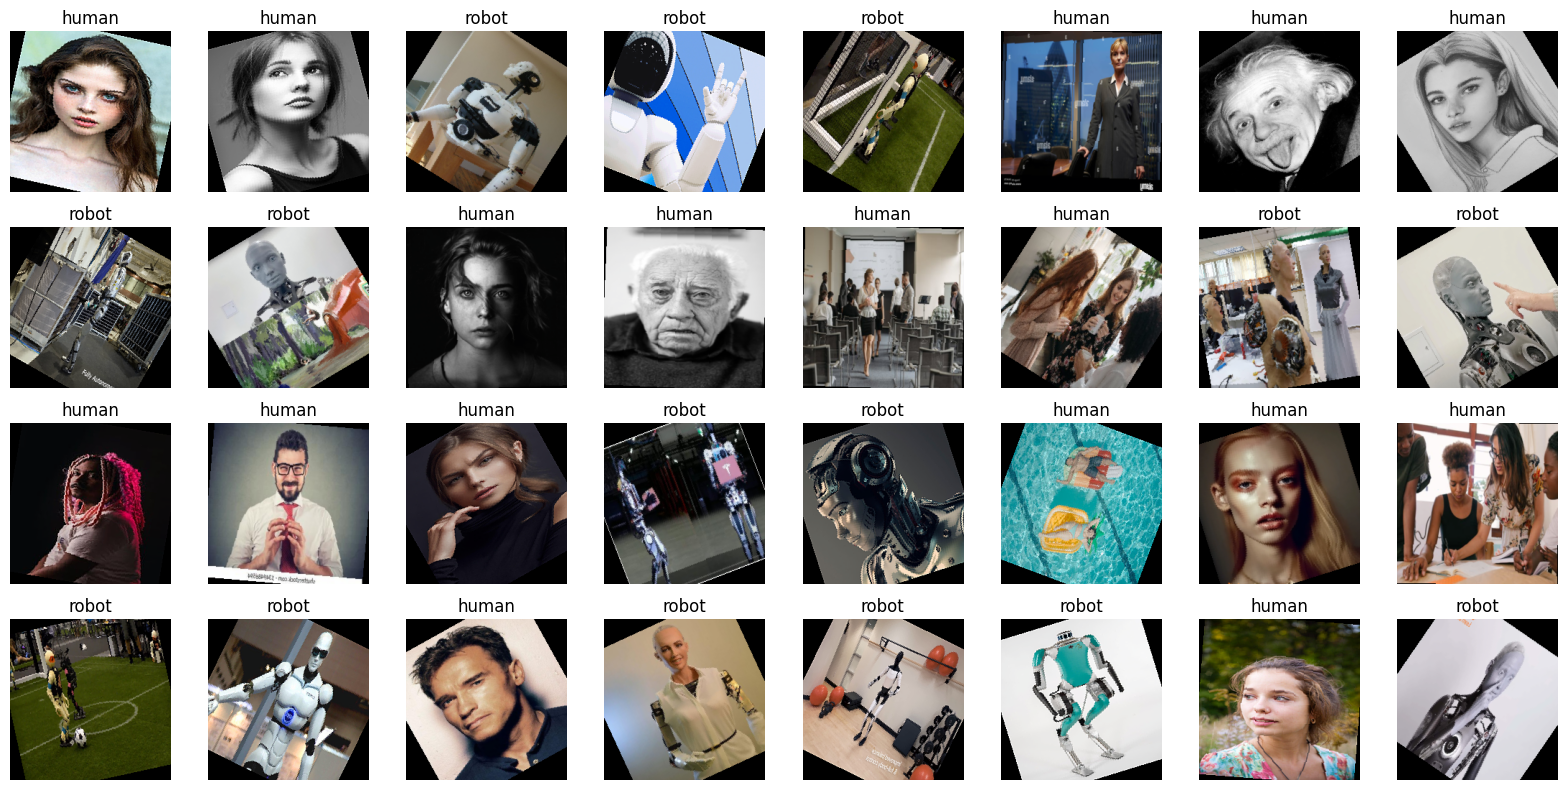

In [4]:
inputs, classes = next(iter(train_loader))
titles = [class_names[x] for x in classes]

show_grid(inputs, titles=titles)

In [5]:
# from torchsummary import summary

swin_t = models.swin_t(weights='DEFAULT').to(device)
# summary(swin_t, input_size= (3,32,32) )

## Running evaluation before fine-tuning the model on our own dataset

In [6]:
criterion = nn.CrossEntropyLoss()

accuracy, loss = eval_model(swin_t, eval_loader= test_loader, criterion= criterion, device= device)

print("Evaluation Accuracy before fine-tuning:" , accuracy)
print('Evaluation Loss before fine-tuning: ', loss)

Evaluation Accuracy before fine-tuning: 0.0
Evaluation Loss before fine-tuning:  8.427101612091064


### 1. End-to-end fine tuining

In [7]:
num_logits = swin_t.head.in_features

swin_t.head = nn.Sequential(
    nn.Linear(num_logits, 512),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(512, 2)
)
# summary(swin_t, input_size= (3,32,32) )


In [8]:
set_random_seed()


In [9]:
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(swin_t.parameters(), lr=1e-4)

scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=2)

In [10]:
# TODO: remove the ".." when integrated in the combined file

TBOARD_LOGS = os.path.join(os.getcwd(),"..", "tboard_logs", "Transformer", "SwinTransformer")

if os.path.exists(TBOARD_LOGS):
    shutil.rmtree(TBOARD_LOGS) # To discard old log files

os.makedirs(TBOARD_LOGS)

writer = SummaryWriter(TBOARD_LOGS)

In [11]:
train_loss, val_loss, loss_iters, valid_acc = train_model(
        model=swin_t, optimizer=optimizer, scheduler=scheduler, criterion=criterion,
        train_loader=train_loader, valid_loader=valid_loader, num_epochs=15, tboard=writer, start_epoch=0
    )


  0%|          | 0/15 [00:00<?, ?it/s]


  7%|▋         | 1/15 [00:12<02:54, 12.43s/it]

Epoch 1/15
    Train loss: 0.44435
    Valid loss: 0.73704
    Accuracy: 35.0%





 13%|█▎        | 2/15 [00:24<02:41, 12.43s/it]


 20%|██        | 3/15 [00:37<02:29, 12.44s/it]


 27%|██▋       | 4/15 [00:50<02:18, 12.59s/it]


 33%|███▎      | 5/15 [01:02<02:05, 12.55s/it]


 40%|████      | 6/15 [01:14<01:52, 12.49s/it]

Epoch 6/15
    Train loss: 0.01899
    Valid loss: 0.00318
    Accuracy: 100.0%





 47%|████▋     | 7/15 [01:27<01:40, 12.50s/it]


 53%|█████▎    | 8/15 [01:39<01:27, 12.46s/it]


 60%|██████    | 9/15 [01:52<01:14, 12.42s/it]


 67%|██████▋   | 10/15 [02:04<01:02, 12.53s/it]


 73%|███████▎  | 11/15 [02:17<00:50, 12.53s/it]

Epoch 11/15
    Train loss: 0.00166
    Valid loss: 0.00038
    Accuracy: 100.0%





 80%|████████  | 12/15 [02:29<00:37, 12.51s/it]


 87%|████████▋ | 13/15 [02:42<00:25, 12.59s/it]


 93%|█████████▎| 14/15 [02:55<00:12, 12.72s/it]


100%|██████████| 15/15 [03:07<00:00, 12.53s/it]


100%|██████████| 15/15 [03:07<00:00, 12.53s/it]

Epoch 15/15
    Train loss: 0.00323
    Valid loss: 0.00029
    Accuracy: 100.0%


Training completed


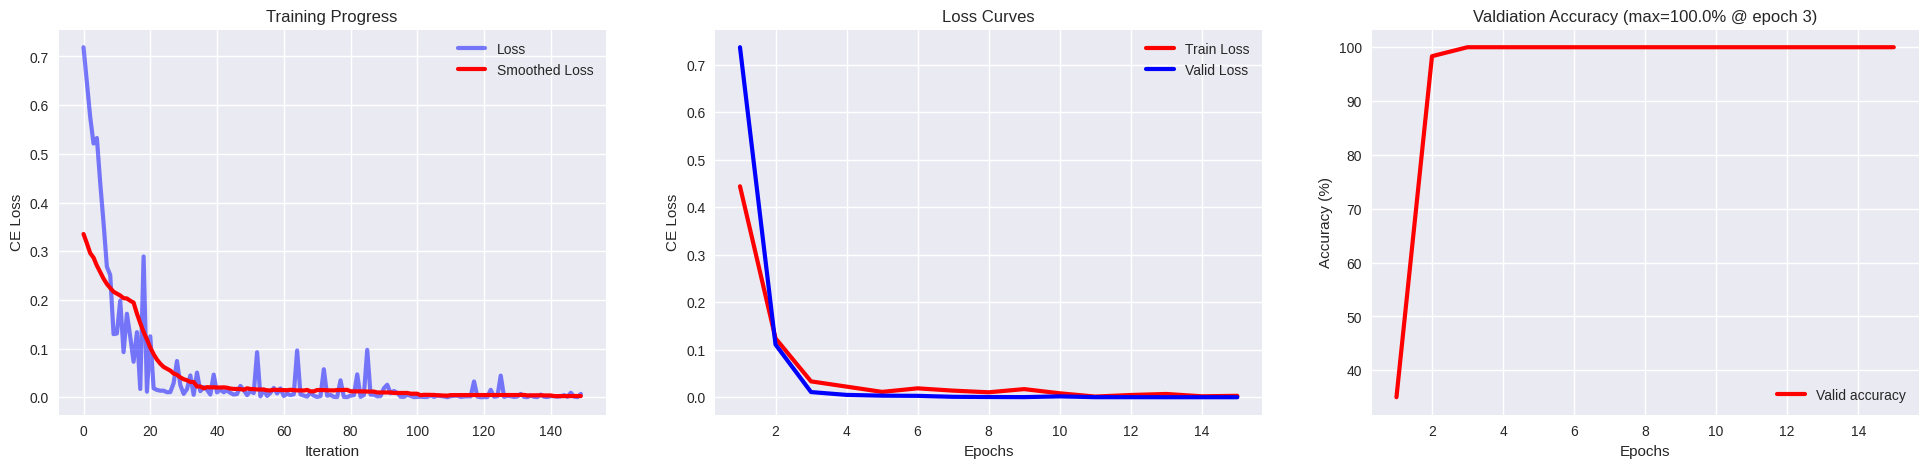

In [12]:
plot(train_loss, val_loss, loss_iters, valid_acc)

### Evaluation

In [13]:
accuracy, loss = eval_model(swin_t, eval_loader= test_loader, criterion= criterion, device= device)

print("Evaluation Accuracy before fine-tuning:" , accuracy)
print('Evaluation Loss before fine-tuning: ', loss)

/home/asolta2s/CudaVisionLab/CudaVisionSS2025/src/venv/lib64/python3.9/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Evaluation Accuracy before fine-tuning: 97.61904761904762
Evaluation Loss before fine-tuning:  0.07605065277311951


### 2. Fine-tuning with freezing backbone

In [14]:
# from torchinfo import summary

swin_t = models.swin_t(weights='DEFAULT').to(device)

for param in swin_t.parameters():
    param.requires_grad = False

swin_t.head = nn.Sequential(
    nn.Linear(num_logits, 512),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(512, 2)
)

# summary(swin_t, col_names=[ "num_params",'trainable'], col_width=14) 

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(swin_t.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=1/3)

train_loss, val_loss, loss_iters, valid_acc = train_model(
        model=swin_t, optimizer=optimizer, scheduler=scheduler, criterion=criterion,
        train_loader=train_loader, valid_loader=valid_loader, num_epochs=15, tboard=writer, start_epoch=0
    )


  0%|          | 0/15 [00:00<?, ?it/s]


  7%|▋         | 1/15 [00:11<02:45, 11.83s/it]

Epoch 1/15
    Train loss: 0.63622
    Valid loss: 0.66395
    Accuracy: 66.66666666666666%





 13%|█▎        | 2/15 [00:23<02:32, 11.74s/it]


 20%|██        | 3/15 [00:35<02:20, 11.68s/it]


 27%|██▋       | 4/15 [00:46<02:08, 11.70s/it]


 33%|███▎      | 5/15 [00:58<01:56, 11.68s/it]


 40%|████      | 6/15 [01:10<01:45, 11.70s/it]

Epoch 6/15
    Train loss: 0.23548
    Valid loss: 0.18026
    Accuracy: 98.33333333333333%





 47%|████▋     | 7/15 [01:22<01:33, 11.75s/it]


 53%|█████▎    | 8/15 [01:33<01:22, 11.72s/it]


 60%|██████    | 9/15 [01:45<01:10, 11.73s/it]


 67%|██████▋   | 10/15 [01:57<00:58, 11.69s/it]


 73%|███████▎  | 11/15 [02:08<00:46, 11.69s/it]

Epoch 11/15
    Train loss: 0.17522
    Valid loss: 0.13254
    Accuracy: 98.33333333333333%





 80%|████████  | 12/15 [02:20<00:35, 11.68s/it]


 87%|████████▋ | 13/15 [02:32<00:23, 11.70s/it]


 93%|█████████▎| 14/15 [02:43<00:11, 11.69s/it]


100%|██████████| 15/15 [02:55<00:00, 11.66s/it]


100%|██████████| 15/15 [02:55<00:00, 11.70s/it]

Epoch 15/15
    Train loss: 0.15736
    Valid loss: 0.12236
    Accuracy: 98.33333333333333%


Training completed


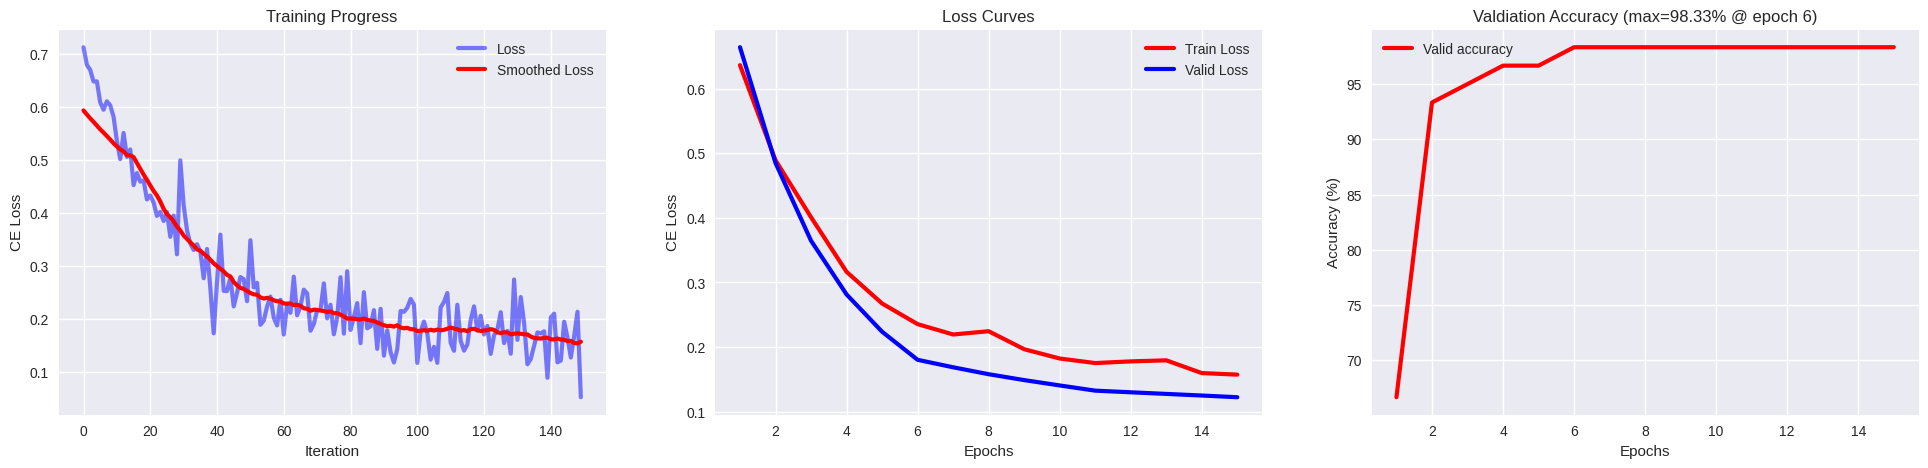

In [16]:
plot(train_loss, val_loss, loss_iters, valid_acc)


### Evaluation

In [17]:
accuracy, loss = eval_model(swin_t, eval_loader= test_loader, criterion= criterion, device= device)

print("Evaluation Accuracy:" , accuracy)
print('Evaluation Loss: ', loss)

/home/asolta2s/CudaVisionLab/CudaVisionSS2025/src/venv/lib64/python3.9/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Evaluation Accuracy: 100.0
Evaluation Loss:  0.13867631554603577


### 3. Combined fine-tuning

In [18]:
swin_t = models.swin_t(weights='DEFAULT').to(device)

for param in swin_t.parameters():
    param.requires_grad = False

swin_t.head = nn.Sequential(
    nn.Linear(num_logits, 512),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(512, 2)
)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(swin_t.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=1/3)

train_loss, val_loss, loss_iters, valid_acc = train_model(
        model=swin_t, optimizer=optimizer, scheduler=scheduler, criterion=criterion,
        train_loader=train_loader, valid_loader=valid_loader, num_epochs=15, tboard=writer, start_epoch=0
    )

# Unfreezing the network
for param in swin_t.parameters():
    param.requires_grad = True

# Reducing the lr
for param in optimizer.param_groups:
    param['lr'] *= 0.2

next_train_loss, next_val_loss, next_loss_iters, next_valid_acc = train_model(
        model=swin_t, optimizer=optimizer, scheduler=scheduler, criterion=criterion,
        train_loader=train_loader, valid_loader=valid_loader, num_epochs=10,  tboard=writer, start_epoch=15
    )

concat_train_loss = train_loss + next_train_loss
concat_val_loss = val_loss + next_val_loss
concat_loss_iters = loss_iters + next_loss_iters
concat_valid_acc = valid_acc + next_valid_acc


  0%|          | 0/15 [00:00<?, ?it/s]


  7%|▋         | 1/15 [00:11<02:42, 11.61s/it]

Epoch 1/15
    Train loss: 0.6197
    Valid loss: 0.69115
    Accuracy: 53.333333333333336%





 13%|█▎        | 2/15 [00:23<02:31, 11.67s/it]


 20%|██        | 3/15 [00:35<02:21, 11.75s/it]


 27%|██▋       | 4/15 [00:46<02:08, 11.70s/it]


 33%|███▎      | 5/15 [00:58<01:57, 11.79s/it]


 40%|████      | 6/15 [01:10<01:46, 11.82s/it]

Epoch 6/15
    Train loss: 0.21923
    Valid loss: 0.17034
    Accuracy: 100.0%





 47%|████▋     | 7/15 [01:22<01:33, 11.72s/it]


 53%|█████▎    | 8/15 [01:33<01:21, 11.69s/it]


 60%|██████    | 9/15 [01:45<01:09, 11.65s/it]


 67%|██████▋   | 10/15 [01:56<00:58, 11.65s/it]


 73%|███████▎  | 11/15 [02:08<00:46, 11.66s/it]

Epoch 11/15
    Train loss: 0.17935
    Valid loss: 0.12504
    Accuracy: 100.0%





 80%|████████  | 12/15 [02:20<00:34, 11.62s/it]


 87%|████████▋ | 13/15 [02:31<00:23, 11.59s/it]


 93%|█████████▎| 14/15 [02:43<00:11, 11.61s/it]


100%|██████████| 15/15 [02:54<00:00, 11.58s/it]


100%|██████████| 15/15 [02:54<00:00, 11.66s/it]

Epoch 15/15
    Train loss: 0.15309
    Valid loss: 0.1159
    Accuracy: 100.0%


Training completed



  0%|          | 0/10 [00:00<?, ?it/s]


 10%|█         | 1/10 [00:11<01:46, 11.84s/it]

Epoch 1/10
    Train loss: 0.16807
    Valid loss: 0.11381
    Accuracy: 100.0%





 20%|██        | 2/10 [00:23<01:34, 11.81s/it]


 30%|███       | 3/10 [00:35<01:23, 11.93s/it]


 40%|████      | 4/10 [00:47<01:11, 11.98s/it]


 50%|█████     | 5/10 [00:59<00:59, 11.97s/it]


 60%|██████    | 6/10 [01:11<00:48, 12.08s/it]

Epoch 6/10
    Train loss: 0.13428
    Valid loss: 0.10168
    Accuracy: 100.0%





 70%|███████   | 7/10 [01:23<00:36, 12.05s/it]


 80%|████████  | 8/10 [01:35<00:24, 12.03s/it]


 90%|█████████ | 9/10 [01:47<00:11, 11.99s/it]


100%|██████████| 10/10 [01:59<00:00, 11.97s/it]


100%|██████████| 10/10 [01:59<00:00, 11.98s/it]

Epoch 10/10
    Train loss: 0.14675
    Valid loss: 0.09852
    Accuracy: 100.0%


Training completed


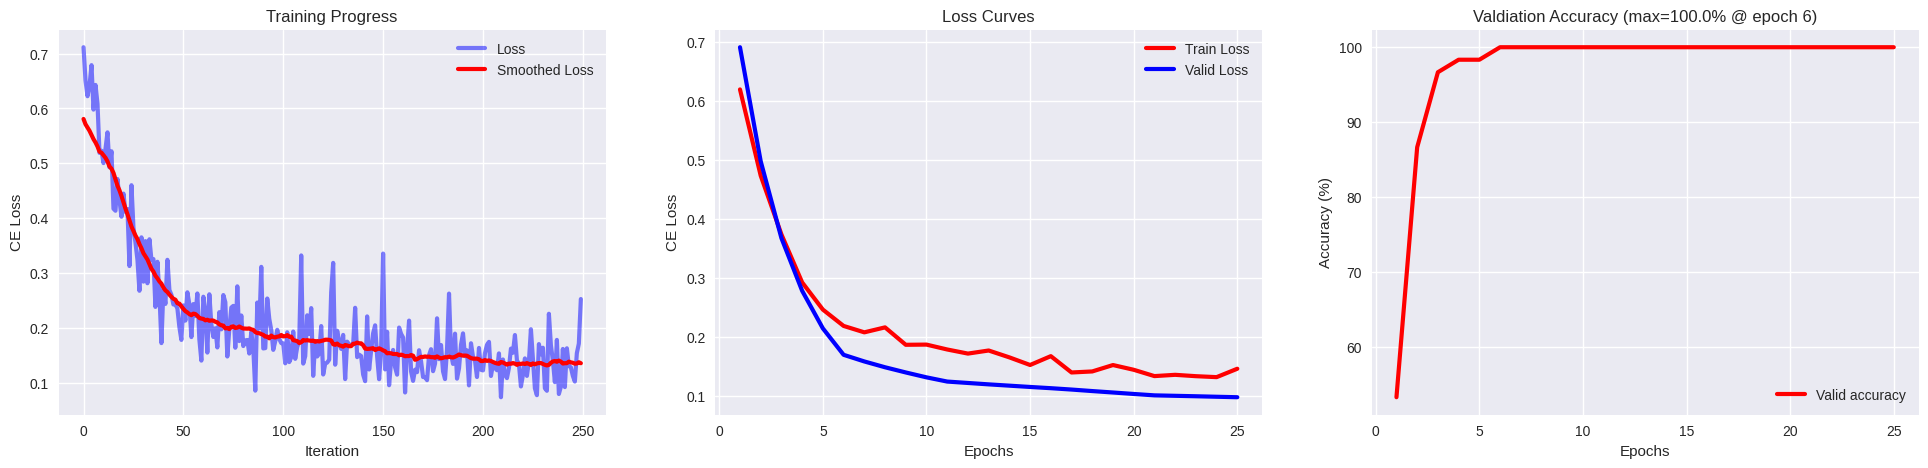

In [19]:
plot(concat_train_loss, concat_val_loss, concat_loss_iters, concat_valid_acc)


### Evaluation

In [20]:
accuracy, loss = eval_model(swin_t, eval_loader= test_loader, criterion= criterion, device= device)

print("Evaluation Accuracy:" , accuracy)
print('Evaluation loss: ', loss)

/home/asolta2s/CudaVisionLab/CudaVisionSS2025/src/venv/lib64/python3.9/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Evaluation Accuracy: 95.23809523809523
Evaluation loss:  0.12295455113053322


# Confusion Matrix

In [ ]:
swin_t = models.swin_t(weights='DEFAULT').to(device)
optimizer = torch.optim.Adam(swin_t.parameters(), lr=1e-4)

model, optimizer, epoch, stats = load_model(model= swin_t,optimizer=optimizer,savepath='../models/checkpoint_freezed_backbone.pth')